# Dataset : 
The dataset contains images extracted from every video from the UCF Crime Dataset.
Every 10th frame is extracted from each full-length video and combined for every video in that class.
All the images are of size 64*64 and in .png format

The dataset has a total of 14 Classes :

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries 

In [2]:
from keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os
from keras.utils import load_img, img_to_array
from tqdm import tqdm
import cv2

# Load Dataset
Here we load it to Train and Test

In [3]:
train_dr = '/kaggle/input/ucf-crime-dataset/Train'
test_dr = '/kaggle/input/ucf-crime-dataset/Test'

# Create Dataframe

In [4]:
def createdataframe(dir):
  image_path =[]
  labels = []
  for label in os.listdir(dir):
    for image in os.listdir(os.path.join(dir,label)):
      image_path.append(os.path.join(dir,label,image))
      labels.append(label)
    print(label,"Completed")
  return image_path,labels


In [5]:
train = pd.DataFrame()
train['image'], train['labels'] = createdataframe(train_dr)

RoadAccidents Completed
Assault Completed
Vandalism Completed
Arrest Completed
Shooting Completed
NormalVideos Completed
Arson Completed
Explosion Completed
Shoplifting Completed
Robbery Completed
Stealing Completed
Burglary Completed
Abuse Completed
Fighting Completed


# Displays a single image per class in a row-wise manner

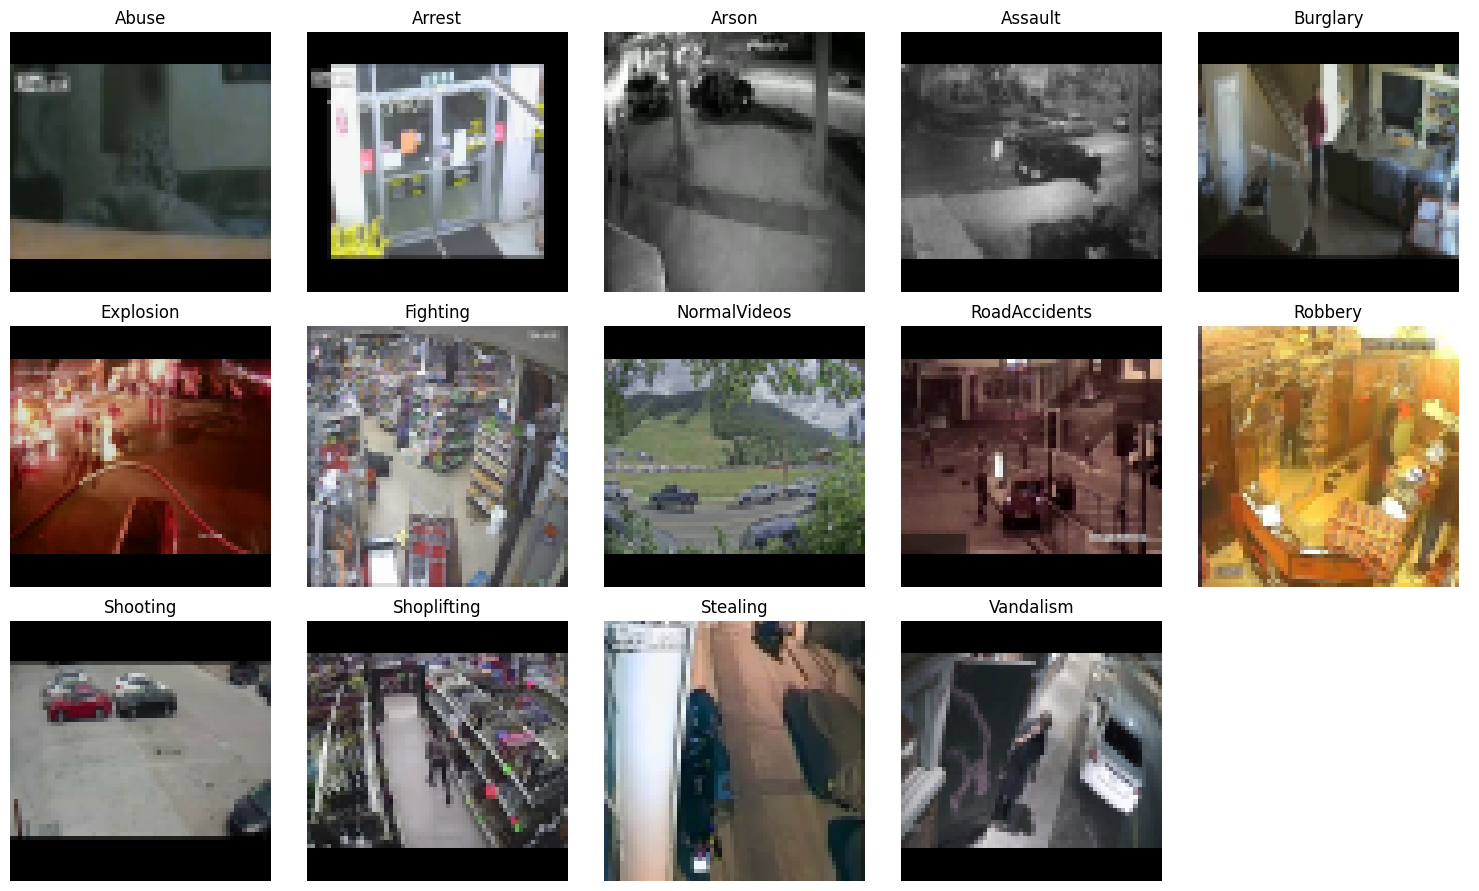

In [6]:
def show_class_images(train_df, num_images_per_class=1):
    classes = sorted(train_df['labels'].unique())  
    num_columns = min(len(classes), 5)
    num_rows = (len(classes) + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 3, num_rows * 3))
    axes = axes.flatten()
    
    for i, class_name in enumerate(classes):
        img_path = train_df[train_df['labels'] == class_name]['image'].iloc[0]  
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis('off')  

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

show_class_images(train)

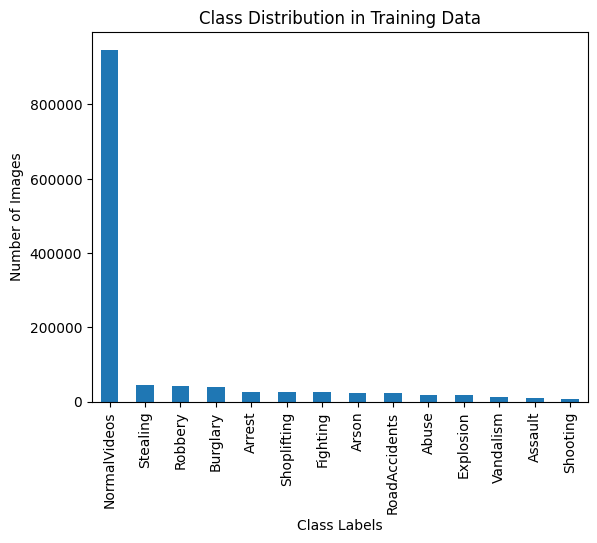

In [7]:
train['labels'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Training Data')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.show()

In [8]:
train

,image,labels
0,/kaggle/input/ucf-crime-dataset/Train/RoadAcci...,RoadAccidents
1,/kaggle/input/ucf-crime-dataset/Train/RoadAcci...,RoadAccidents
2,/kaggle/input/ucf-crime-dataset/Train/RoadAcci...,RoadAccidents
3,/kaggle/input/ucf-crime-dataset/Train/RoadAcci...,RoadAccidents
4,/kaggle/input/ucf-crime-dataset/Train/RoadAcci...,RoadAccidents
...,...,...
1266340,/kaggle/input/ucf-crime-dataset/Train/Fighting...,Fighting
1266341,/kaggle/input/ucf-crime-dataset/Train/Fighting...,Fighting
1266342,/kaggle/input/ucf-crime-dataset/Train/Fighting...,Fighting
1266343,/kaggle/input/ucf-crime-dataset/Train/Fighting...,Fighting


In [9]:
test = pd.DataFrame()
test['image'], test['labels'] = createdataframe(test_dr)

RoadAccidents Completed
Assault Completed
Vandalism Completed
Arrest Completed
Shooting Completed
NormalVideos Completed
Arson Completed
Explosion Completed
Shoplifting Completed
Robbery Completed
Stealing Completed
Burglary Completed
Abuse Completed
Fighting Completed


# Class Count

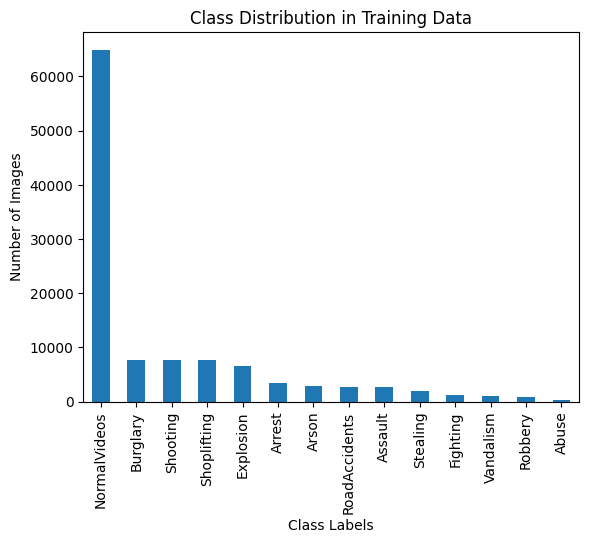

In [10]:
test['labels'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Training Data')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.show()

# Class Balance

In [12]:

# Desired counts
train_normal_count = 50000

# Separate the majority class
train_majority = train[train['labels'] == 'NormalVideos']
train_minority = train[train['labels'] != 'NormalVideos']

# Downsample the majority class
train_majority_downsampled = train_majority.sample(
    n=train_normal_count, random_state=42
)

# Combine with minority classes
train_balanced = pd.concat([train_majority_downsampled, train_minority])

# Shuffle the dataset
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Train Class Distribution:")
print(train_balanced['labels'].value_counts())


Balanced Train Class Distribution:
labels
NormalVideos    50000
Stealing        44802
Burglary        39504
Shoplifting     24835
Fighting        24684
Abuse           19076
Explosion       18753
Assault         10360
Shooting         7140
Name: count, dtype: int64


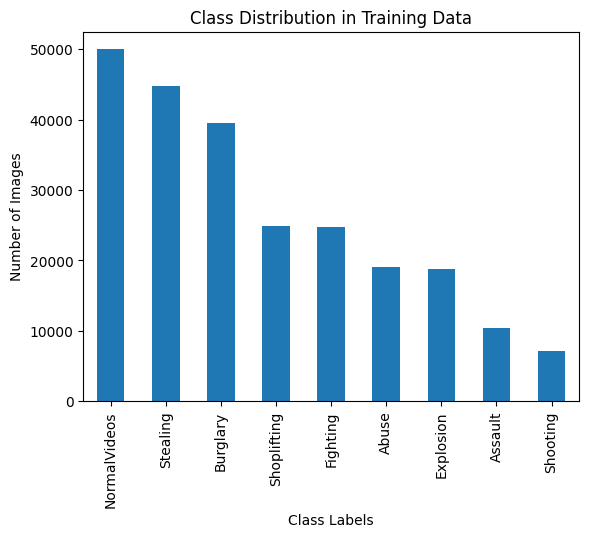

In [13]:
train_balanced['labels'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Training Data')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.show()

# Extract Features
### Resize images from 64x64 to 48x48
### Turn RGB to Gray scale

In [14]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale', target_size=(48, 48))  # Added target_size
        img_array = img_to_array(img)
        features.append(img_array)

    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [15]:
train_features = extract_features(train_balanced['image'])

100%|██████████| 239154/239154 [39:35<00:00, 100.68it/s]


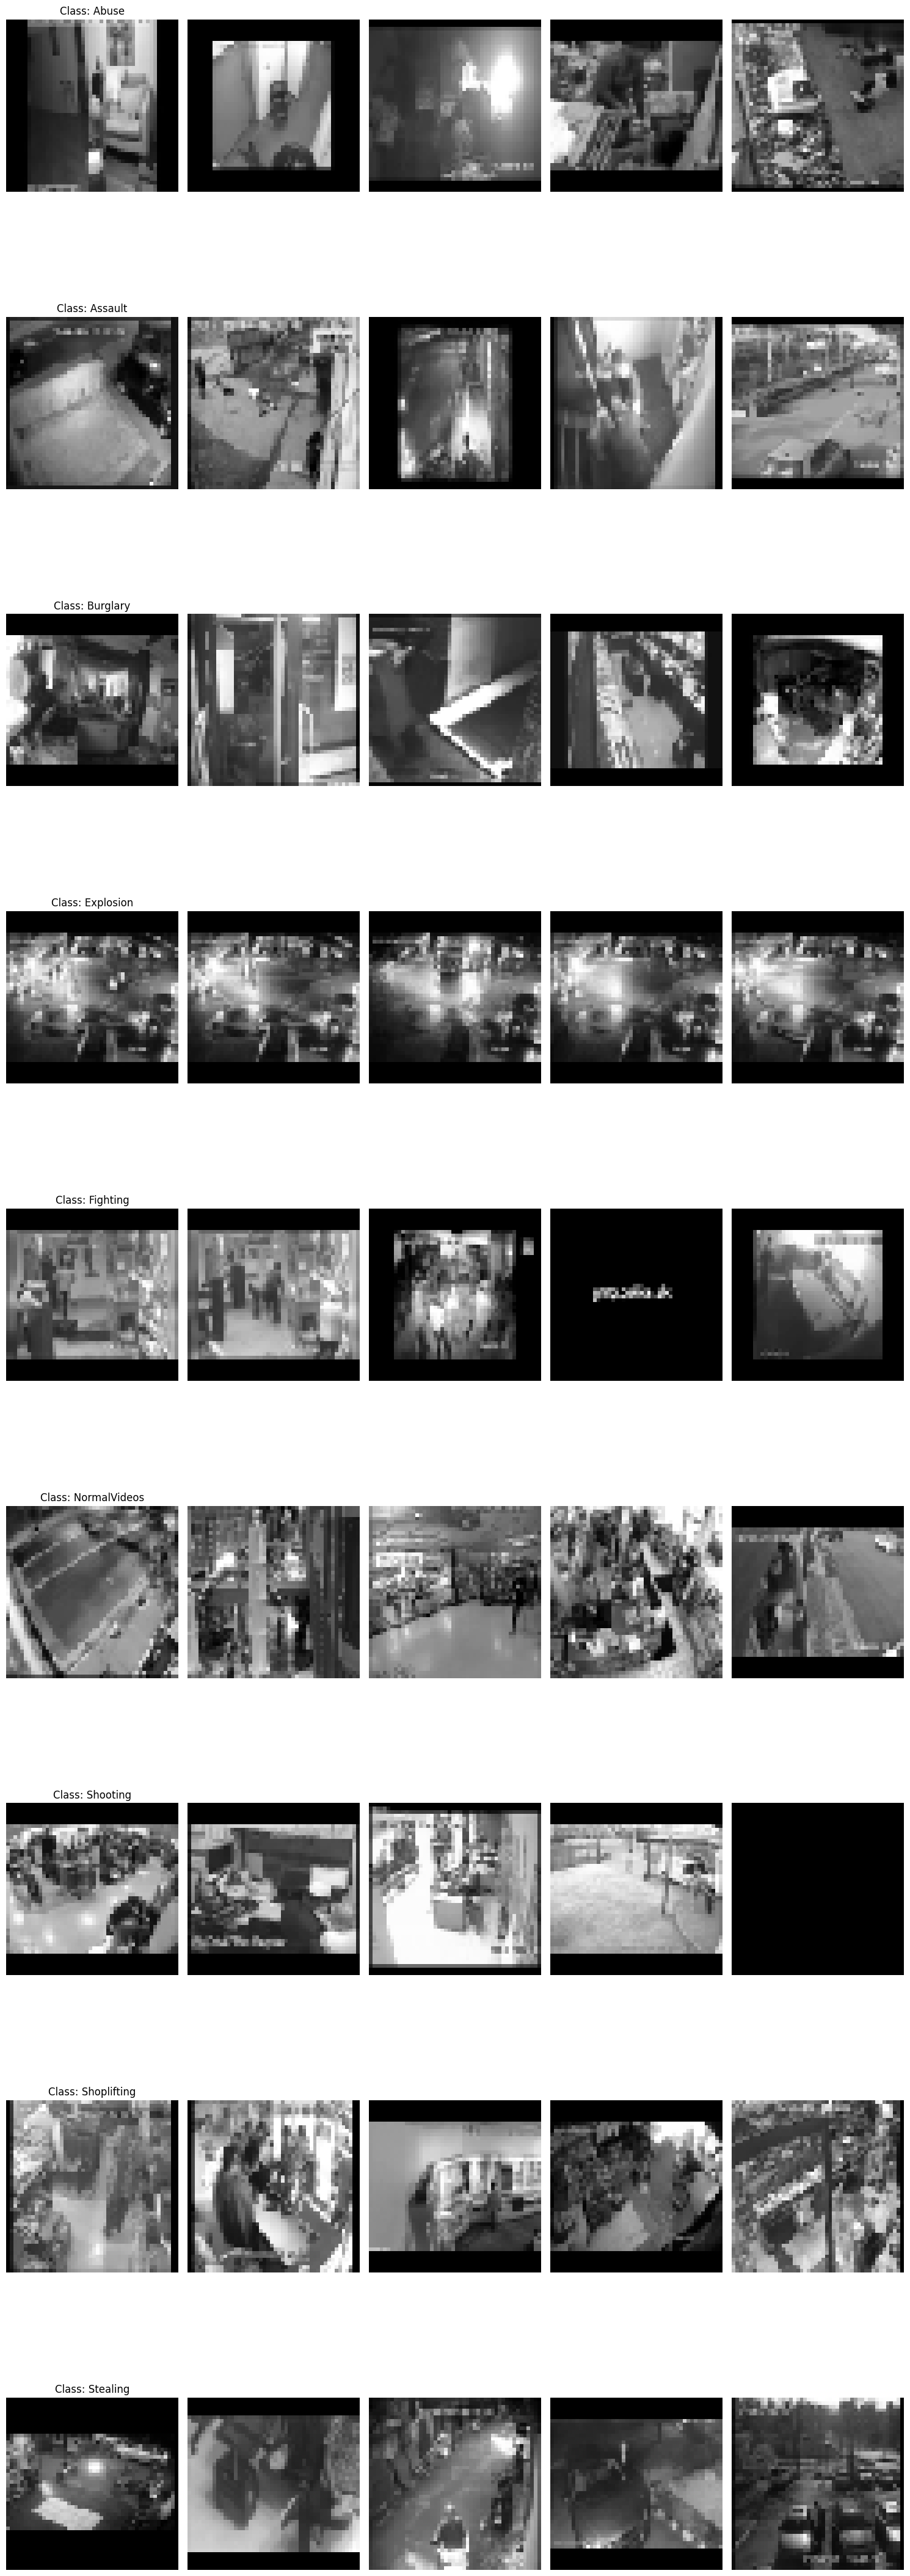

In [16]:

unique_classes = np.unique(train_balanced['labels'])


fig, axes = plt.subplots(len(unique_classes), 5, figsize=(15, 5 * len(unique_classes)))  # Adjust number of columns (5 here)
axes = axes.flatten()  # Flatten the axes array for easier access

# Loop through each class and display images row-wise
for idx, class_label in enumerate(unique_classes):
    class_images = train_balanced[train_balanced['labels'] == class_label].iloc[:5]  # Display 5 images per class
    for i, (_, row) in enumerate(class_images.iterrows()):
        # Get the corresponding image index from the train_balanced DataFrame
        img_index = row.name
        img = train_features[img_index]  # Directly index into train_features
        
        axes[idx * 5 + i].imshow(img.reshape(48, 48), cmap='gray')
        axes[idx * 5 + i].axis('off')  # Turn off axis for better visualization

    # Add title for each class
    axes[idx * 5].set_title(f'Class: {class_label}')

# Show the plot
plt.tight_layout()
plt.show()


In [17]:
test_features = extract_features(test['image'])

100%|██████████| 100541/100541 [14:49<00:00, 113.02it/s]


# Normalize

In [18]:
features = train_features/255.0

In [19]:
labels = train_balanced['labels']

# Label Encoding

In [20]:
le = LabelEncoder()
labels = le.fit_transform(labels)  

# Split Train into train and test 
20% test and 80% train

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Defining the CNN Model Architecture

#### We now begin defining the layers of our CNN. The model consists of several convolutional blocks followed by fully connected layers. 

#### Description:
##### - The model starts with an input layer that accepts grayscale images of size 48x48.

##### - It then applies four convolutional blocks, each consisting of a Conv2D layer for feature extraction, MaxPooling2D for reducing the spatial dimensions, and Dropout to regularize the model.

##### - After the convolutional layers, the model is flattened and passed through two dense layers before the output layer, which has 9 units (one for each class) and uses softmax activation to output class probabilities.

#### Summary of Activation Functions:
##### ReLU: Used in the hidden layers (convolutional and dense) to introduce non-linearity and improve learning efficiency.
##### Softmax: Used in the output layer for multi-class classification tasks to output probabilities for each class.
##### Dropout: Used between layers to prevent overfitting by randomly deactivating a fraction of the neurons.

In [22]:


model = Sequential()


model.add(Input(shape=(48, 48, 1)))


model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))


model.add(Dense(9, activation='softmax'))


# Compile the model

The model.compile() function configures the model for training by defining the optimizer, loss function, and evaluation metrics:

Optimizer: Adam

Adam is used for efficient weight updates with adaptive learning rates, helping the model converge faster. A learning rate of 0.001 is commonly used.
Loss Function: Sparse Categorical Crossentropy

This is suitable for multi-class classification with integer labels, calculating how well the predicted class probabilities match the true labels.
Metrics: Accuracy

Accuracy measures the percentage of correct predictions, helping track the model's performance during training.

In [23]:

model.compile(
    optimizer=Adam(learning_rate=0.001),  
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

# Train the model

In [24]:

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_test, y_test)
)

Epoch 1/5
5979/5979 ━━━━━━━━━━━━━━━━━━━━ 109s 17ms/step - accuracy: 0.6647 - loss: 0.9674 - val_accuracy: 0.9679 - val_loss: 0.1078
Epoch 2/5
5979/5979 ━━━━━━━━━━━━━━━━━━━━ 97s 16ms/step - accuracy: 0.9357 - loss: 0.2196 - val_accuracy: 0.9805 - val_loss: 0.0665
Epoch 3/5
5979/5979 ━━━━━━━━━━━━━━━━━━━━ 97s 16ms/step - accuracy: 0.9495 - loss: 0.1755 - val_accuracy: 0.9849 - val_loss: 0.0586
Epoch 4/5
5979/5979 ━━━━━━━━━━━━━━━━━━━━ 97s 16ms/step - accuracy: 0.9554 - loss: 0.1592 - val_accuracy: 0.9842 - val_loss: 0.0592
Epoch 5/5
5979/5979 ━━━━━━━━━━━━━━━━━━━━ 96s 16ms/step - accuracy: 0.9584 - loss: 0.1522 - val_accuracy: 0.9861 - val_loss: 0.0480


# Evaluate the model

In [25]:

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

1495/1495 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9876 - loss: 0.0454
Test Loss: 0.04803895577788353, Test Accuracy: 0.9861387014389038


# classification report

In [26]:

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  


report = classification_report(y_test, y_pred_classes, target_names=le.classes_)
print("Classification Report:\n", report)


1495/1495 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9876 - loss: 0.0454
Test Loss: 0.04803895577788353, Test Accuracy: 0.9861387014389038
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Classification Report:
               precision    recall  f1-score   support

       Abuse       0.99      0.97      0.98      3902
     Assault       1.00      0.96      0.98      2044
    Burglary       1.00      0.99      0.99      8025
   Explosion       0.99      0.98      0.99      3753
    Fighting       1.00      0.98      0.99      4959
NormalVideos       0.96      0.99      0.97     10028
    Shooting       0.99      0.97      0.98      1432
 Shoplifting       1.00      1.00      1.00      4992
    Stealing       0.99      1.00      0.99      8696

    accuracy                           0.99     47831
   macro avg       0.99      0.98      0.99     47831
weighted avg       0.99      0.99      0.99     47831



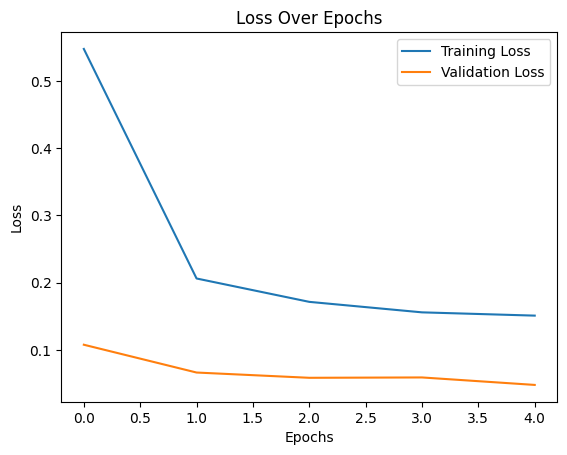

In [27]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

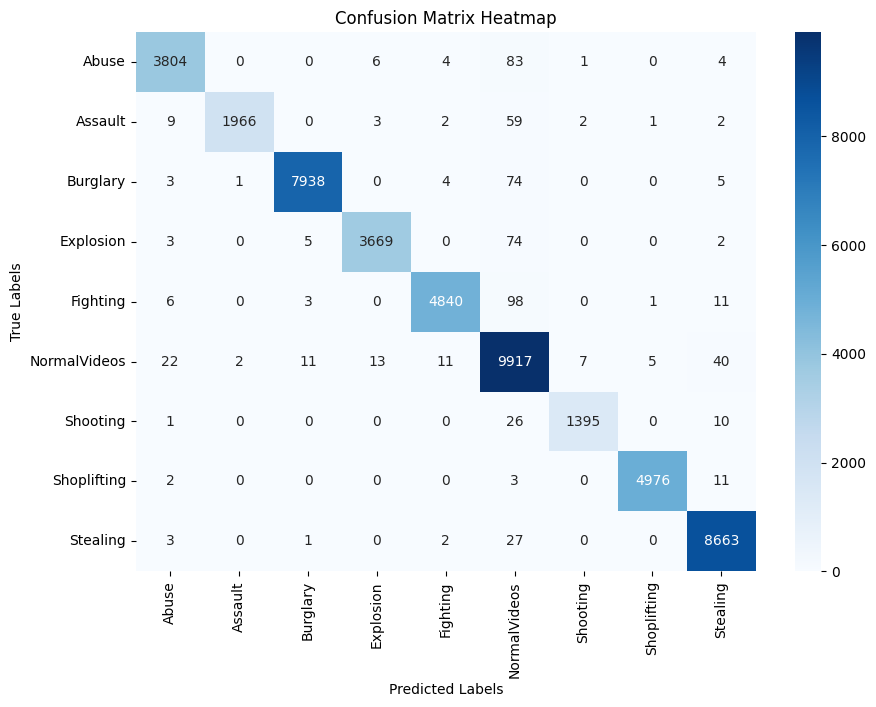

In [28]:

conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [29]:
model.save('/kaggle/working/my_model.h5')